Step 13.2: Cavity Flow with Upwind Sheme
----
***

Here is the system of differential equations: two equations for the velocity components $u,v$ and one equation for pressure:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) $$


$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) $$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = \rho\left(\frac{\partial}{\partial t}\left(\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y} \right) - \frac{\partial u}{\partial x}\frac{\partial u}{\partial x}-2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}-\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$

### Discretized equations

As before, let's rearrange the equations in the way that the iterations need to proceed in the code. First, the momentum equations for the velocity at the next time step.


The momentum equation in the $u$ direction:

$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} Upwind() - v_{i,j}^{n} \frac{\Delta t}{\Delta y} Upwind() \\
& - \frac{\Delta t}{\rho 2\Delta x} \left(p_{i+1,j}^{n}-p_{i-1,j}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\right)\right)
\end{split}
$$

The momentum equation in the $v$ direction:

$$
\begin{split}
v_{i,j}^{n+1} = v_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} Upwind() - v_{i,j}^{n} \frac{\Delta t}{\Delta y} Upwind() \\
& - \frac{\Delta t}{\rho 2\Delta y} \left(p_{i,j+1}^{n}-p_{i,j-1}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\right)\right)
\end{split}
$$

Almost there! Now, we rearrange the pressure-Poisson equation:

$$
\begin{split}
p_{i,j}^{n} = & \frac{\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}\right) \Delta y^2 + \left(p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \Delta x^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& -\frac{\rho\Delta x^2\Delta y^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& \times \left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

The initial condition is $u, v, p = 0$ everywhere, and the boundary conditions are:

$u=1$ at $y=2$ (the "lid");

$u, v=0$ on the other boundaries;

$\frac{\partial p}{\partial y}=0$ at $y=0$;

$p=0$ at $y=2$

$\frac{\partial p}{\partial x}=0$ at $x=0,2$



In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
nx = 41
ny = 41
nt = 500 
nit = 50
c = 1
length = 1
dx = length / (nx-1)
dy = length / (ny-1)
x = np.linspace(0,length,nx)
y = np.linspace(0,length,ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = 0.01
dt = 0.001

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
b = np.zeros((ny,nx))

print("Reynold's number =", c*length/nu)

Reynold's number = 100.0


The pressure Poisson equation that's written above can be hard to write out without typos.  The function `build_up_b` below represents the contents of the square brackets, so that the entirety of the PPE is slightly more manageable.  
$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = \rho\left(\frac{\partial}{\partial t}\left(\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y} \right) - \frac{\partial u}{\partial x}\frac{\partial u}{\partial x}-2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}-\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$

In [3]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))


    return b

The function `pressure_poisson` is also defined to help segregate the different rounds of calculations.  Note the presence of the pseudo-time variable `nit`.  This sub-iteration in the Poisson calculation helps ensure a divergence-free field.  

In [4]:
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [5]:
# This is another version of pressure_poisson function with l1norm_target
def pressure_poisson_l1norm(p, dx, dy, b, l1norm_target):
    pn = np.empty_like(p)
    pn = p.copy()

    l1norm = 1
    small = 1e-8
    niter = 0
    while l1norm > l1norm_target:
        niter += 1   # count the number of iterations for convergence
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        l1norm = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
        
    return p, niter

In [6]:
def velocity_u_update(u, dx, dy, dt, rho, p, un, vn):
    
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / dx *
                    (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                    dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    return u

def velocity_v_update(v, dx, dy, dt, rho, p, un, vn):
    
    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return v

def compute_F(c):
    denom = abs(c) + 1e-6
    pos_part = np.maximum(c/denom, 0)
    neg_part = np.maximum(-c/denom, 0)
    return pos_part, neg_part

def velocity_u_upwind_update(u, dx, dy, dt, rho, p, un, vn):
    #F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
    #F_vectorized = np.vectorize(F) # vectorize function F to support element-wise operations on arrays
    fe1, fe2 = compute_F(un)       
    fw1, fw2 = fe1, fe2
    ue = un[1:-1, 1:-1] * fe1[1:-1, 1:-1] + un[1:-1, 2:] * fe2[1:-1, 1:-1]     
    uw = un[1:-1, 0:-2] * fw1[1:-1, 1:-1] + un[1:-1, 1:-1]* fw2[1:-1, 1:-1]

    fnorth1, fnorth2 = compute_F(vn)       
    fs1, fs2 = fnorth1, fnorth2
    unorth = un[1:-1, 1:-1] * fnorth1[1:-1, 1:-1] + un[2:, 1:-1] * fnorth2[1:-1, 1:-1]     
    us = un[0:-2, 1:-1] * fs1[1:-1, 1:-1] + un[1:-1, 1:-1]* fs2[1:-1, 1:-1]
   
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                    un[1:-1, 1:-1] * dt / dx *
                    (ue - uw) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (unorth - us) -
                    dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                    nu * (dt / dx**2 *
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
    return u

def velocity_v_upwind_update(v, dx, dy, dt, rho, p, un, vn):
    
    #F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
    #F_vectorized = np.vectorize(F) # vectorize function F to support element-wise operations on arrays
    fe1, fe2 = compute_F(un)       
    fw1, fw2 = fe1, fe2
    ve = vn[1:-1, 1:-1] * fe1[1:-1, 1:-1] + vn[1:-1, 2:] * fe2[1:-1, 1:-1]     
    vw = vn[1:-1, 0:-2] * fw1[1:-1, 1:-1] + vn[1:-1, 1:-1]* fw2[1:-1, 1:-1]

    fnorth1, fnorth2 = compute_F(vn)       
    fs1, fs2 = fnorth1, fnorth2
    vnorth = vn[1:-1, 1:-1] * fnorth1[1:-1, 1:-1] + vn[2:, 1:-1] * fnorth2[1:-1, 1:-1]     
    vs = vn[0:-2, 1:-1] * fs1[1:-1, 1:-1] + vn[1:-1, 1:-1]* fs2[1:-1, 1:-1]
    
    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                    un[1:-1, 1:-1] * dt / dx *
                    (ve - vw) -
                    vn[1:-1, 1:-1] * dt / dy *
                    (vnorth - vs) -
                    dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                    nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                    dt / dy**2 *
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return v



# a = np.ones((5,5))
# F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
# F_vectorized = np.vectorize(F)
# a1,a2=F_vectorized(a)
# a1

Finally, the rest of the cavity flow equations are wrapped inside the function `cavity_flow`, allowing us to easily plot the results of the cavity flow solver for different lengths of time.  

In [7]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    pn = np.empty_like(p)
    b = np.zeros((ny, nx))
    small = 1e-8    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        pn = p.copy()
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        #p = pressure_poisson(p, dx, dy, b)
        p, niter = pressure_poisson_l1norm(p, dx, dy, b, 1e-4)
        #print(niter)

        #u = velocity_u_update(u, dx, dy, dt, rho, p, un, vn)
        #v = velocity_v_update(v, dx, dy, dt, rho, p, un, vn)
        u = velocity_u_upwind_update(u, dx, dy, dt, rho, p, un, vn)
        v = velocity_v_upwind_update(v, dx, dy, dt, rho, p, un, vn)
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = c    # set velocity on cavity lid equal to c
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
    l1norm_u = (np.sum(np.abs(u[:]-un[:])) / (np.sum(np.abs(un[:]))+small))
    l1norm_v = (np.sum(np.abs(v[:]-vn[:])) / (np.sum(np.abs(vn[:]))+small))
    l1norm_p = (np.sum(np.abs(p[:]-pn[:])) / (np.sum(np.abs(pn[:]))+small))
    print("l1norm_u = ",  l1norm_u, "l1norm_v = ",  l1norm_v, "l1norm_p = ",  l1norm_p)
    return u, v, p

In [8]:
#%%timeit -r 1 -n 1
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 10000
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

l1norm_u =  8.399270188737967e-07 l1norm_v =  1.19159565053719e-06 l1norm_p =  7.473131575199101e-07


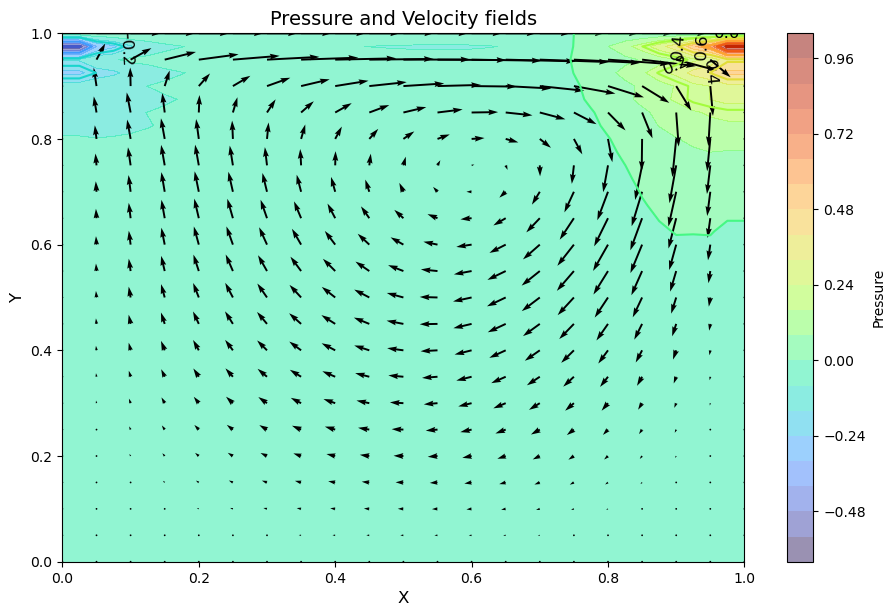

In [9]:
# Create figure and set dpi and figure size
fig = plt.figure(figsize=(11,7), dpi=100)

# Contourf plot for pressure field with colorbar
cf = plt.contourf(X, Y, p, alpha=0.5, cmap='turbo', levels=20)
plt.colorbar(cf, label='Pressure')

# Contour plot for pressure field outlines
contour = plt.contour(X, Y, p, cmap='turbo', levels=10)
plt.clabel(contour, inline=False, fontsize=12, colors = 'black')

# Quiver plot for velocity field
quiv = plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 

# Setting labels for the x and y axes
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)

# Setting the title for the plot
plt.title('Pressure and Velocity fields', fontsize=14)

# Display the plot
plt.show()

The quiver plot shows the magnitude of the velocity at the discrete points in the mesh grid we created.
(We're actually only showing half of the points because otherwise it's a bit of a mess.  The `X[::2, ::2]` syntax above is a convenient way to ask for every other point.)

Another way to visualize the flow in the cavity is to use a `streamplot`:

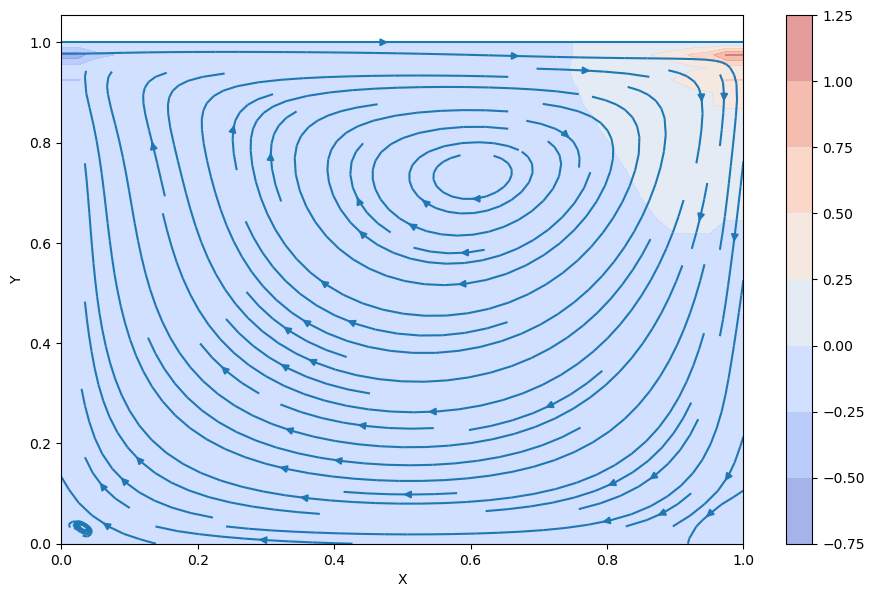

In [10]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.coolwarm)
plt.colorbar()
#plt.contour(X, Y, p, cmap=cm.coolwarm)
plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Y');

### Benchmark using a reference data (Ghia-1982)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the txt file
with open('Ghia-1982.txt', 'r') as file:
    lines = file.readlines()

# Adjust the lines range to match your data
lines = lines[5:-7]  # Adjust these numbers

# Process lines to obtain data
data = [list(map(float, line.split())) for line in lines]

# Create DataFrame from data
df = pd.DataFrame(data, columns=['y', 'Re=100', 'Re=400', 'Re=1000', 'Re=3200', 'Re=5000', 'Re=7500', 'Re=10000'])

# Set y as index
df.set_index('y', inplace=True)

# Plotting
# plt.figure(figsize=(10,8))
# for column in df.columns:
#     plt.plot(df[column].values, df.index.values, label=column) # use .values to get numpy arrays

# plt.xlabel('u-velocity')
# plt.ylabel('y')
# plt.title('u-velocity for different y and Re')
# plt.legend()
# plt.gca().invert_yaxis()  # To invert y-axis
# plt.grid(True)
# plt.show()

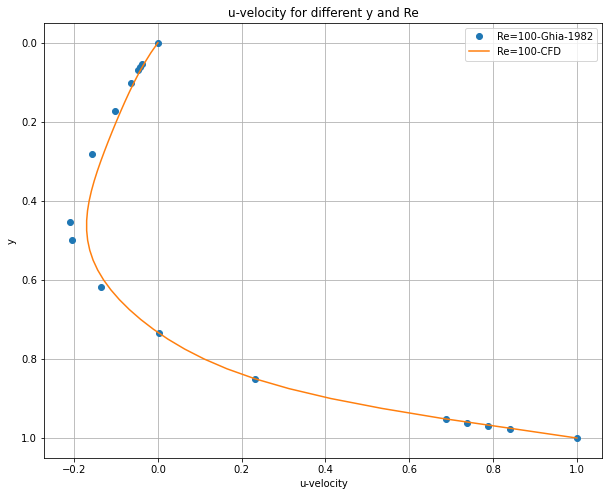

In [12]:
# Plotting
plt.figure(figsize=(10,8))

plt.plot(df['Re=100'].values, df.index.values, 'o', label='Re=100-Ghia-1982') # use .values to get numpy arrays
plt.plot(u[:,int(ny/2)], y, label='Re=100-CFD') # 

plt.xlabel('u-velocity')
plt.ylabel('y')
plt.title('u-velocity for different y and Re')
plt.legend()
plt.gca().invert_yaxis()  # To invert y-axis
plt.grid(True)
plt.show()

### Try a case with Re = 400 and what happens?

In [13]:
rho = 1
c= 8
nu = 0.01
dt = 0.001

u = np.zeros((ny,nx))
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))
b = np.zeros((ny,nx))

print("Reynold's number =", c*length/nu)

Reynold's number = 800.0


l1norm_u =  8.817146489760057e-09 l1norm_v =  1.2799953634449487e-08 l1norm_p =  9.852120741727945e-09


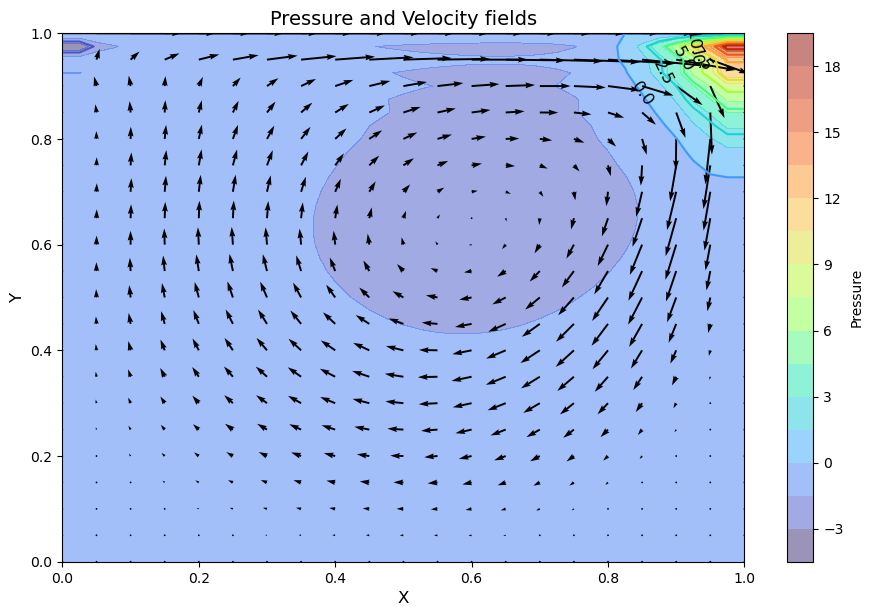

In [14]:
nt = 10000
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

# Create figure and set dpi and figure size
fig = plt.figure(figsize=(11,7), dpi=100)

# Contourf plot for pressure field with colorbar
cf = plt.contourf(X, Y, p, alpha=0.5, cmap='turbo', levels=20)
plt.colorbar(cf, label='Pressure')

# Contour plot for pressure field outlines
contour = plt.contour(X, Y, p, cmap='turbo', levels=10)
plt.clabel(contour, inline=False, fontsize=12, colors = 'black')

# Quiver plot for velocity field
quiv = plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 

# Setting labels for the x and y axes
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)

# Setting the title for the plot
plt.title('Pressure and Velocity fields', fontsize=14)

# Display the plot
plt.show()

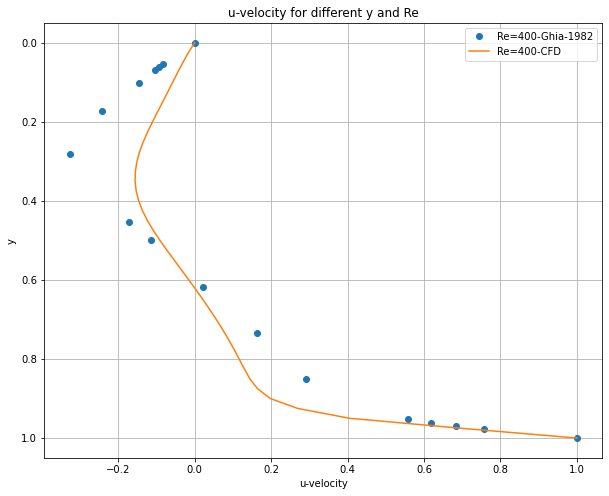

In [15]:
# Plotting
plt.figure(figsize=(10,8))

plt.plot(df['Re=400'].values, df.index.values, 'o', label='Re=400-Ghia-1982') # use .values to get numpy arrays
plt.plot(u[:,int(ny/2)]/c, y, label='Re=400-CFD') # 

plt.xlabel('u-velocity')
plt.ylabel('y')
plt.title('u-velocity for different y and Re')
plt.legend()
plt.gca().invert_yaxis()  # To invert y-axis
plt.grid(True)
plt.show()

### What happened?

We adopted the upwind scheme for the convection term, enabling the numerical results to accommodate high Reynolds number scenarios. However, when benchmarked against Ghia's high-fidelity results, our outcomes with high Reynolds numbers deviated in accuracy. The accuracy can be improved by increasing the number of nodes.